---
**Autores**: Prof. João Nogueira e Prof. Dino Magri

**Contato**: `joaonogueira@fisica.ufc.br` e `professor.dinomagri@gmail.com`

**Licença deste notebook**: 
<br>
<img align="left" width="80" src="https://licensebuttons.net/l/by/3.0/88x31.png" />

<br>
<br>

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)


---

# Regressão

Em regressão, queremos prever um valor contínuo, como o preço de um imóvel, a altura de uma pessoa, a receita de um jogo no primeiro mês de lançamento e etc.

Basicamente todas as técnicas estudadas até aqui de cross-validation, otimização de hiperparâmetros e feature selection, também servem para problemas de regressão. 

A grande diferença entre regressão e classificação é o tipo de dados que queremos prever e as métricas utilizadas para avaliarmos a performance.

Iremos usar o dataset de previsão de preços de casas disponível no kaggle ([House Prices: Advanced Regression Tecniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/)).

Sugiro fortemente como leitura complementar explorar os notebooks dessa competição e aprender com os competidores e quem sabe até participar da competição!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Carregando os dados

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/datasets/house_prices_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
df.shape

(1460, 81)

In [15]:
# selecionando o target
target = 'SalePrice'

# construindo uma lista com os nomes apenas das variáveis categóricas
cat_vars = df.select_dtypes(include='object').columns.to_list()

# lista apenas com os nomes das variáveis numéricas
num_vars = [col for col in df.columns if col not in cat_vars + ['Id', target]]

# separando a base em treino e teste
X = df.filter(cat_vars + num_vars).copy()
y = df['SalePrice'].copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=30)

## Aplicando a RandomForestRegressor

In [ ]:
# instalando o pacote feature-engine
!pip install feature-engine

In [20]:
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

model = Pipeline(steps=[
    ('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=-999, variables=num_vars)),
    ('categoric_imputer', CategoricalImputer(fill_value='Missing', variables=cat_vars)),
    ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
    ('random_forest', RandomForestRegressor(n_estimators=500, max_depth=5, random_state=30)) # Para testar: Utilize diferente algoritmos.
])

In [21]:
model.fit(X_train, y_train)
y_previsto = model.predict(X_test)
y_esperado = y_test.copy()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


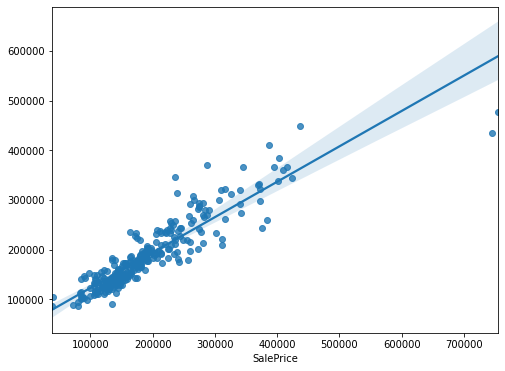

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(y_esperado, y_previsto, ax=ax);

## Computando as Métricas
- R2 e R2 Ajustado
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)
- RMSLE (Root Mean Squared Logarithmic Error)
- MAE (Mean Absolute Error)
- MedAE (Median Absolute Percentage Error)
- MAPE (Mean Absolute Percentage Error)


Como vimos, algumas dessas métricas são afetadas por outliers, então vamos testar com e sem outliers.

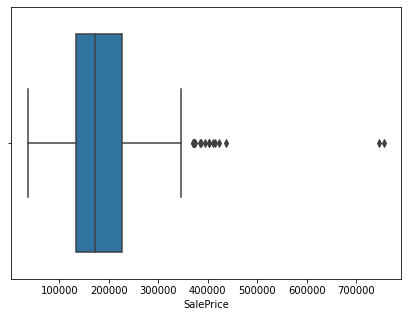

In [23]:
fig, ax = plt.subplots(figsize=(7,5))

sns.boxplot(x=y_esperado);

In [24]:
# Vamos remover valores maiores que 340000
y_esperado_sem_outlier = y_esperado[y_esperado < 340000]
y_previsto_sem_outlier = y_previsto[y_esperado < 340000]

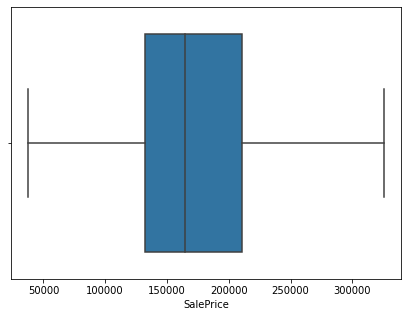

In [25]:
fig, ax = plt.subplots(figsize=(7,5))

sns.boxplot(x=y_esperado_sem_outlier);

### R2 e R2 Ajustado

In [26]:
from sklearn.metrics import r2_score

r2 = r2_score(y_esperado, y_previsto)
r2_sem_outliers = r2_score(y_esperado_sem_outlier, y_previsto_sem_outlier)

print('R2 COM outliers:', r2)
print('R2 SEM outliers:', r2_sem_outliers)

R2 COM outliers: 0.8096448906157545
R2 SEM outliers: 0.7881637396533124


In [27]:
def adjusted_r2(y_esperado, y_previsto, X_treino):
  r2 = r2_score(y_esperado, y_previsto)
  N = len(y_esperado)
  p = X_treino.shape[1]

  r2_ajustado = (1 - ((1 - r2) * (N - 1)) / (N - p - 1))
  return r2_ajustado

In [28]:
r2_ajustado = adjusted_r2(y_esperado, y_previsto, X_train)
r2_ajustado_sem_outliers = r2_score(y_esperado_sem_outlier, y_previsto_sem_outlier)

print('R2 Ajustado COM outliers:', r2_ajustado)
print('R2 Ajustado SEM outliers:', r2_ajustado_sem_outliers)

R2 Ajustado COM outliers: 0.7387106753263423
R2 Ajustado SEM outliers: 0.7881637396533124


### MSE

A ideia é calcular a diferença entre o valor previsto e o valor esperado.

In [29]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_esperado, y_previsto)
mse_sem_outliers = mean_squared_error(y_esperado_sem_outlier, y_previsto_sem_outlier)

print('MSE COM outliers:', mse)
print('MSE SEM outliers:', mse_sem_outliers)

MSE COM outliers: 1479612664.0668263
MSE SEM outliers: 695629796.8584789


### RMSE

*Root Mean Squared Error*

*Raiz Quadrada do Erro médio*

- Mesma unidade da medida original (por isso tiramos a raiz quadrada)
- Erros maiores são mais penalizados (muito afetado por outliers)

In [30]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mse)
rmse_sem_outliers = np.sqrt(mse_sem_outliers)

print('RMSE COM outliers:', rmse)
print('RMSE SEM outliers:', rmse_sem_outliers)

RMSE COM outliers: 38465.73363484474
RMSE SEM outliers: 26374.794726376145


Tirando os outliers, o `rmse` melhora bastante. Muitas vezes pode acontecer de quebrarmos o problema de regressão em 2: criar um modelo para os pontos normais e outro modelo para outliers.

RMSE COM outliers: 38465.73363484474
RMSE SEM outliers: 26374.794726376145


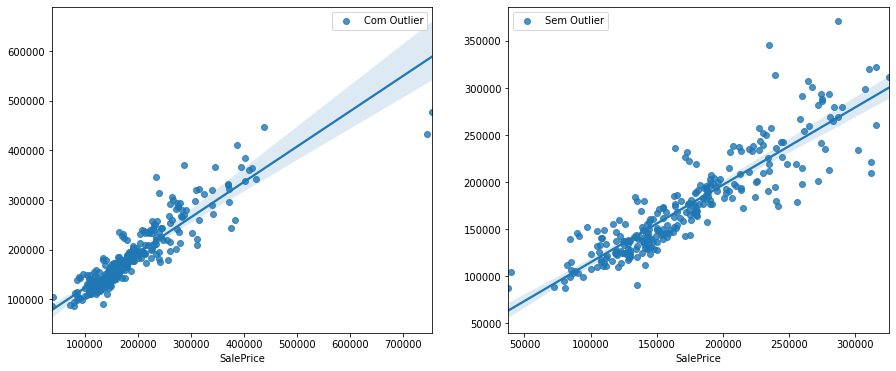

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.regplot(x=y_esperado, y=y_previsto, label='Com Outlier', ax=ax[0]);
sns.regplot(x=y_esperado_sem_outlier, y=y_previsto_sem_outlier, label='Sem Outlier', ax=ax[1]);
ax[0].legend();
ax[1].legend();

print('RMSE COM outliers:', rmse)
print('RMSE SEM outliers:', rmse_sem_outliers)

### RMSLE

*Root Mean Squared Logarithmic Error*

*Raiz Quadrado do Erro Logarítmico Médio*

- Aproximação do erro percentual
- `RMSE` se importa mais com a diferença simples, enquanto o `RMSLE` se importa com a diferença relativa (logs).
- É mais robusta a outliers


In [32]:
from sklearn.metrics import mean_squared_log_error

In [33]:
rmsle = np.sqrt(mean_squared_log_error(y_esperado, y_previsto))
rmsle_sem_outlier = np.sqrt(mean_squared_log_error(y_esperado_sem_outlier, y_previsto_sem_outlier))

print('RMSLE COM outliers:', rmsle)
print('RMSLE SEM outliers:', rmsle_sem_outlier)

RMSLE COM outliers: 0.16934695626209356
RMSLE SEM outliers: 0.163085232119064


### MAE

*Mean Absolute Error*

*Erro Médio Absoluto*

- Sofre menos efeitos de outliers
- Usa o valor absoluto em contraste com o `mse`, por isso sofre menos os efeitos dos outliers

In [36]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_esperado, y_previsto)
mae_sem_outliers = mean_absolute_error(y_esperado_sem_outlier, y_previsto_sem_outlier)
print('MAE COM outliers:', mae)
print('MAE SEM outliers:', mae_sem_outliers)

MAE COM outliers: 22439.63767203987
MAE SEM outliers: 18466.743877707537


### MedAE - Median Absolute Error

*Median Absolute Error*

*Erro Mediano Absoluto*

In [37]:
from sklearn.metrics import median_absolute_error

medae = median_absolute_error(y_esperado, y_previsto)
medae_sem_outlier = median_absolute_error(y_esperado_sem_outlier, y_previsto_sem_outlier)

print('MAE COM outliers:', medae)
print('MAE SEM outliers:', medae_sem_outlier)

MAE COM outliers: 13267.203861229107
MAE SEM outliers: 12155.359891293294


Metade dos erros absolutos estão abaixo de 13267 para os dados com outliers e 12155 para os dados sem outliers.

### MAPE

*Mean Absolute Percent Error*

*Erro Médio Absoluto Percentual*

In [38]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))

In [40]:
from sklearn.metrics import median_absolute_error

mape = calculate_mape(y_esperado, y_previsto)
mape_sem_outlier = calculate_mape(y_esperado_sem_outlier, y_previsto_sem_outlier)

print('MAPE Sem Outlier:', mape)
print('MAPE Com Outlier:', mape_sem_outlier)

MAPE Sem Outlier: 0.12192452148360522
MAPE Com Outlier: 0.1189021269154375


Erramos em média 12%.